In [1]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools

pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

#--------------------------------FUNCIONES--------------------------------#

def transform_MIDAS(df, pv, join_pv = False):
    # --- Define columns to extract ---
    colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
    colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
    colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"]

    # --- First Filter: Y_PREDICCION --- Filtro de valores nulos? por que habria valores nulos? 
    df1 = df[colNames] #df["Y_PREDICCION"].notna()]

    # --- Second Filter: Y_PRONOSTICOS --- Filtro de valores nulos? por que habria valores nulos?
    df2 = df[colNames2] #f["Y_PRONOSTICOS"].notna()

    df2.columns = colNames  # Rename to match df1

    df3 = df[df.MODEL == "BayesianRidge"][colNames3]
    #df3 ["MODEL"] = "Y_HIST"
    df3["Y_HIST"] = df3["Y_HIST"].astype(float)
    #df3 = df3.groupby(["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"])[["Y_HIST"]]
    
    # --- Combine both filtered datasets ---
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # --- Reorder columns: move Y_PREDICCION next to MODEL ---
    cols = combined_df.columns.tolist()

    y_pred_idx = cols.index("Y_PREDICCION")

    model_idx = cols.index("MODEL")

    cols.insert(model_idx + 1, cols.pop(y_pred_idx))

    combined_df = combined_df[cols]

    combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

    

    #display(combined_df.FECHA.value_counts().sort_index())
    res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()

    res["MAX_MODEL"] = True

    res = res.merge(df3, on = ["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], how = "outer", validate = "1:1")

    res = res.rename(columns = {"NOMBREGRUPOESTADISTICO3": "GE3", "NOMBRESUBDIRECCION": "NombreSubdireccion"})

    res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)
    
    res["FECHA"] = pd.to_datetime(res["FECHA"])
    
    if join_pv == True:

        out = pv.merge(res, how = "left", on = ["FECHA", "NombreSubdireccion", "GE3" ] ,validate = "1:1")
        
        out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)
        
        return out
    else:

        return res
    

def load_pv(query_str):

    client = bigquery.Client(project="demanda-prj-dev")

    consulta = query_str

    query = client.query(consulta)

    pv = query.to_dataframe(create_bqstorage_client=True)

    pv.sort_index(inplace=True, ascending=True)

    pv["PVO"] = pv["PVO"].astype(float)

    pv["PV"] = pv["PV"].astype(float)

    pv["FACT"] = pv["FACT"].astype(float).fillna(0)

    #pv["MAX"] = pv["MAX"].astype(float)

    pv["id"] = pv['NombreGrupo'] + "_" + pv['NombreDireccion'] + "_" + pv['NombreSubdireccion'] + "_" + pv['GE1'] + "_" + pv['GE2'] + "_" + pv['GE3']

    # Obtener todos los valores únicos de cada columna clave
    fechas = pv['FECHA'].unique()
    
    id = pv['id'].unique()

    # Generar todas las combinaciones posibles
    combinaciones = pd.DataFrame(list(itertools.product(fechas, id)), columns=['FECHA',"id"])
    for i, col  in enumerate(["NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"]):
        print(i, col)
        combinaciones[col] = combinaciones["id"].str.split("_").apply(lambda x:x[i])

    # Unir con el DataFrame original
    df_completo = pd.merge(combinaciones, pv, on=["FECHA","id","NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"], how='left')

    df_completo["FACT"] = df_completo["FACT"].fillna(np.nan)

    df_completo["valid_ton"] = df_completo.PVO.fillna(0) + df_completo.FACT.fillna(0)

    df_completo["FECHA"] = pd.to_datetime(df_completo["FECHA"])

    pv = df_completo.copy()
    
    return pv

date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-03-01


In [8]:
qery_last_model_v2 = """SELECT
 `FECHA_EJECUCION`,
  `FECHA`,
  `COV%`,
  `MAPE%`,
  `MODEL`,
  `NOMBREGRUPOESTADISTICO3`,
  `NOMBRESUBDIRECCION`,
  `Y_HIST`,
  `Y_PREDICCION`,
  `Y_PRONOSTICOS`,
  `Y_TEST`
FROM `demanda-prj-dev.pronosticos.forecast_table`
WHERE FECHA_EJECUCION = (SELECT MAX( FECHA_EJECUCION ) FROM `demanda-prj-dev.pronosticos.forecast_table` WHERE TEST = '0')
ORDER BY FECHA ASC
"""


def load_query(query_str):

  client = bigquery.Client(project="demanda-prj-dev")

  consulta = query_str

  query = client.query(consulta)

  forecast = query.to_dataframe()

  forecast.sort_index(inplace=True, ascending=True)

  forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)

  forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)

  forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)

  forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

  print(forecast.FECHA.value_counts().sort_index().tail(5))

  return forecast

df = load_query(qery_last_model_v2)

df.head()

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


FECHA
2025-10-01    4208
2025-11-01    4208
2025-12-01    4208
2026-01-01    4208
2026-02-01    4208
Name: count, dtype: int64


,FECHA_EJECUCION,FECHA,COV%,MAPE%,MODEL,NOMBREGRUPOESTADISTICO3,NOMBRESUBDIRECCION,Y_HIST,Y_PREDICCION,Y_PRONOSTICOS,Y_TEST
0,2025-09-18 08:07:36,2024-09-01,27.232,19.835,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1109.79151,NaN,NaN,NaN
1,2025-09-18 08:07:36,2024-09-01,37.5304,32.1801,RandomForestRegressor,PANEL,AGRICULTURAL DISTRIBUTION,755.71740,NaN,NaN,NaN
2,2025-09-18 08:07:36,2024-09-01,28.9967,20.9705,RandomForestRegressor,HORSE FENCE,AGRICULTURAL DISTRIBUTION,409.81385,NaN,NaN,NaN
3,2025-09-18 08:07:36,2024-09-01,35.0897,52.0842,RandomForestRegressor,ALAMBRE DE PÚAS,AGRICULTURAL DISTRIBUTION,456.63800,NaN,NaN,NaN
4,2025-09-18 08:07:36,2024-09-01,41.1705,55.1817,RandomForestRegressor,MALLA GRADUADA,AGRICULTURAL DISTRIBUTION,304.74300,NaN,NaN,NaN


In [22]:
df.groupby(["FECHA","MODEL"]).agg({ "Y_PRONOSTICOS":"sum"}).unstack(-1).tail(10)

# --- Define columns to extract ---
colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]


# --- First Filter: Y_PREDICCION --- Filtro de valores nulos? por que habria valores nulos? 
df1 = df[df["Y_PREDICCION"].notna()][colNames]

# --- Second Filter: Y_PRONOSTICOS --- Filtro de valores nulos? por que habria valores nulos?
df2 = df[df["Y_PRONOSTICOS"].notna()][colNames2]
df2.columns = colNames  # Rename to match df1
# --- Combine both filtered datasets ---
combined_df = pd.concat([df1, df2], ignore_index=True)

# --- Reorder columns: move Y_PREDICCION next to MODEL ---
cols = combined_df.columns.tolist()

y_pred_idx = cols.index("Y_PREDICCION")

model_idx = cols.index("MODEL")

cols.insert(model_idx + 1, cols.pop(y_pred_idx))

combined_df = combined_df[cols]

combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

display(combined_df.FECHA.value_counts().sort_index())

res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()

res["MAX_MODEL"] = True

res = res.rename(columns = {"NOMBREGRUPOESTADISTICO3": "GE3", "NOMBRESUBDIRECCION": "NombreSubdireccion"})

res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)

#out = pv.merge(res, how = "left", on = ["FECHA", "NombreSubdireccion", "GE3" ] ,validate = "1:1")

#out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

res.groupby("FECHA")[[ 'BayesianRidge',
       'GradientBoostingRegressor', 'KNeighborsRegressor', 'LGBMRegressor',
       'RandomForestRegressor', 'Ridge', 'SVR', 'XGBRegressor']].sum().round(0)


FECHA
2025-03-01    4208
2025-04-01    4208
2025-05-01    4208
2025-06-01    4208
2025-07-01    4208
2025-08-01    4208
2025-09-01    4208
2025-10-01    4208
2025-11-01    4208
2025-12-01    4208
2026-01-01    4208
2026-02-01    4208
Name: count, dtype: int64

MODEL,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor
FECHA,,,,,,,,
2025-03-01,6.632213e+16,208141.0,207428.0,205109.0,207420.0,208359.0,203827.0,211576.0
2025-04-01,1.475715e+23,203861.0,205725.0,202663.0,204735.0,201944.0,206010.0,204925.0
2025-05-01,5.508392e+25,202187.0,207599.0,210821.0,200327.0,201833.0,202406.0,201760.0
2025-06-01,2.849183e+29,199603.0,203539.0,209426.0,200045.0,198554.0,203942.0,202962.0
2025-07-01,4.050140e+37,206483.0,208505.0,207423.0,203618.0,215398.0,206077.0,207988.0
2025-08-01,3.910505e+38,205493.0,203153.0,211794.0,202726.0,200836.0,201639.0,204609.0
2025-09-01,2.159760e+05,208684.0,213992.0,210162.0,206544.0,209171.0,203830.0,208036.0
2025-10-01,2.077060e+05,202385.0,210807.0,200020.0,203543.0,201861.0,203660.0,201463.0
2025-11-01,2.042630e+05,201793.0,209525.0,209310.0,201180.0,201716.0,203885.0,200785.0


In [20]:
res.columns

Index(['FECHA', 'NombreSubdireccion', 'GE3', 'BayesianRidge',
       'GradientBoostingRegressor', 'KNeighborsRegressor', 'LGBMRegressor',
       'RandomForestRegressor', 'Ridge', 'SVR', 'XGBRegressor', 'MAX_MODEL'],
      dtype='object', name='MODEL')

In [22]:
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

query_str = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS FECHA,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS GE1,
nom_grupo_estadistico2 AS GE2,
nom_grupo_estadistico3 AS GE3,
sum(toneladas_facturadas) AS FACT,
sum(toneladas_pvo) AS PVO,
sum(toneladas_plan_ventas) AS PV
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE 
EXTRACT(YEAR FROM fecha) >= 2022
AND
EXTRACT(YEAR FROM fecha) < 2026
AND
nom_direccion NOT IN ('ABASTECIMIENTOS', 'IIDEA NACIONAL')   #('FILIALES') --> lo quité de la consulta duplica SUBDIRG3
#AND
#nom_subdireccion NOT IN  ('SERVICIOS LOGISTICOS DAL USA') --> lo quité de la consulta duplica SUBDIRG3
-- Descartamos los siguientes campos
AND
nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
#AND
#nom_direccion NOT IN ('EXPORTACIÓN ALAMBRES')
#AND
#nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
AND
nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS', 'SEGUNDAS')
#AND
#nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
#AND
#nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND nom_grupo IS NOT NULL
AND nom_direccion IS NOT NULL
AND nom_subdireccion IS NOT NULL
AND nom_grupo_estadistico1 IS NOT NULL
AND nom_grupo_estadistico2 IS NOT NULL
AND nom_grupo_estadistico3 IS NOT NULL
AND  mes_anio IS NOT NULL
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1,2,3,4,5,6,7
"""

pv = load_pv(query_str)

#display(pv.FECHA.value_counts())

pv.sample(5)

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 GE1
4 GE2
5 GE3


,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,FACT,PVO,PV,valid_ton
10278,2022-06-01,ALAMBRES_ALAMBRES_NORTE_MALLAS Y ALAMBRES_NEGR...,ALAMBRES,ALAMBRES,NORTE,MALLAS Y ALAMBRES,NEGROS ANTAAC,ESCALERILLA,10.71811,6.89700,7.29100,17.61511
93552,2025-12-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_VARILLA...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,VARILLA,VARILLA,VARILLA 3/8,0.00000,NaN,NaN,0.00000
41352,2023-10-01,ALAMBRES_ALAMBRES_CENTRO SUR_MALLAS Y ALAMBRES...,ALAMBRES,ALAMBRES,CENTRO SUR,MALLAS Y ALAMBRES,FERRETEROS,ALAMBRE BOBINA,2.34000,4.63098,4.63098,6.97098
71565,2025-01-01,USA_EUA - CANADA_CONSTRUCTION DISTRIBUTION_MAL...,USA,EUA - CANADA,CONSTRUCTION DISTRIBUTION,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PANEL,0.00000,NaN,NaN,0.00000
48609,2024-01-01,DEACERO SOLUTIONS_INGETEK_COMERCIAL MEXICO EDI...,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO EDIFICACION,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,ALAMBRE DE PÚAS PVC,0.00000,NaN,NaN,0.00000


In [ ]:
df-

,FECHA_EJECUCION,FECHA,COV%,MAPE%,MODEL,NOMBREGRUPOESTADISTICO3,NOMBRESUBDIRECCION,Y_HIST,Y_PREDICCION,Y_PRONOSTICOS,Y_TEST
0,2025-09-18 08:07:36,2024-09-01,27.232,19.835,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1109.79151,None,None,None
1,2025-09-18 08:07:36,2024-09-01,37.5304,32.1801,RandomForestRegressor,PANEL,AGRICULTURAL DISTRIBUTION,755.7174,None,None,None
2,2025-09-18 08:07:36,2024-09-01,28.9967,20.9705,RandomForestRegressor,HORSE FENCE,AGRICULTURAL DISTRIBUTION,409.81385,None,None,None
3,2025-09-18 08:07:36,2024-09-01,35.0897,52.0842,RandomForestRegressor,ALAMBRE DE PÚAS,AGRICULTURAL DISTRIBUTION,456.638,None,None,None
4,2025-09-18 08:07:36,2024-09-01,41.1705,55.1817,RandomForestRegressor,MALLA GRADUADA,AGRICULTURAL DISTRIBUTION,304.743,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
75739,2025-09-18 08:07:36,2026-02-01,42.7188,25.3224,GradientBoostingRegressor,VARILLA 1 1/4,TURIA,None,None,493.8907,None
75740,2025-09-18 08:07:36,2026-02-01,131.9906,0.0,GradientBoostingRegressor,ALAMBRON TREFILAR MYA,TURIA,None,None,92.0186,None
75741,2025-09-18 08:07:36,2026-02-01,19.2457,6.7993,GradientBoostingRegressor,ALAMBRE LAMINADO CORRUGADO,TURIA,None,None,853.2295913609712,None
75742,2025-09-18 08:07:36,2026-02-01,51.5919,38.9051,GradientBoostingRegressor,CLAVO 2-5,TURIA,None,None,44.8744,None


In [35]:
pv.groupby("FECHA")[["FACT","PVO","PV"]].sum().reset_index()

,FECHA,FACT,PVO,PV
0,2022-01-01,277003.789268,280038.96000,288444.320000
1,2022-02-01,266855.480368,262988.07400,249506.495000
2,2022-03-01,332781.140720,275208.36100,282886.713000
3,2022-04-01,298339.205545,312882.77900,319002.211000
4,2022-05-01,283317.505605,346376.09600,330735.842000
5,2022-06-01,300409.137457,335480.38600,328974.418000
6,2022-07-01,247634.163489,296469.63700,298848.193000
7,2022-08-01,254280.666960,253903.74000,271417.194000
8,2022-09-01,253794.087030,245516.04300,244006.661000
9,2022-10-01,243724.430048,260811.50100,260758.559000


In [23]:
import os
import pandas as pd
LIST_DIR ="../../bd/Facturacion BQ/MIDAS/20250917"

list_df = []
for path in  os.listdir(LIST_DIR):
    print(path)
    df =pd.read_excel(LIST_DIR + "/" + path)
    list_df.append(df)
    del df

base = pd.concat(list_df)

del list_df

base_t = transform_MIDAS(base, pv, join_pv= True)


outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_161539.csv
outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_165447.csv
outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_164343.csv
outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_162506.csv
outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_153852.csv
outputs_Ridge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_163425.csv
outputs_SVR_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_160602.csv
outputs_XGBRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250917_155648.csv


C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2395961182.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)
C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2395961182.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)


In [24]:
base_t = transform_MIDAS(base, pv, join_pv= True)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2395961182.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)
C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2395961182.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)


In [25]:
base_t.groupby(["MAX_MODEL","FECHA"])[["Y_HIST", "FACT"]].sum()

Y_HIST           FACT
MAX_MODEL FECHA                                   
False     2022-01-01       0.000000  277003.789268
          2022-02-01       0.000000  266855.480368
          2022-03-01       0.000000  332781.140720
          2022-04-01       0.000000  298339.205545
          2022-05-01       0.000000  283317.505605
          2022-06-01       0.000000  300409.137457
          2022-07-01       0.000000  247634.163489
          2022-08-01       0.000000  254280.666960
          2022-09-01       0.000000  253794.087030
          2022-10-01       0.000000  243724.430048
          2022-11-01       0.000000  267689.157656
          2022-12-01       0.000000  263959.162146
          2023-01-01       0.000000  315687.116062
          2023-02-01       0.000000  284187.849101
          2023-03-01       0.000000  333126.688013
          2023-04-01       0.000000  271392.465788
          2023-05-01       0.000000  256031.100198
          2023-06-01       0.000000  254237.887498
          2023-07-01       0.000000  240584.590859
          2023-08-01       0.000000  252092.268864
          2023-09-01       0.000000  261472.664014
          2023-10-01       0.000000  292043.201809
          2023-11-01       0.000000  279871.716655
          2023-12-01       0.000000  280723.659225
          2024-01-01       0.000000  289721.879577
          2024-02-01       0.000000  219479.159082
          2024-03-01       0.000000  195214.108826
          2024-04-01       0.000000  261314.308482
          2024-05-01       0.000000  235025.920622
          2024-06-01       0.000000  224929.081847
          2024-07-01  163008.566853  212954.237732
          2024-08-01  165172.827131  223693.841560
          2024-09-01  160472.859780  199406.059258
          2024-10-01  165996.179064  210348.045806
          2024-11-01  163656.733256  212775.475339
          2024-12-01  143114.451494  194106.955650
          2025-01-01       0.000000   47316.098290
          2025-02-01       0.000000   38058.186612
          2025-03-01       0.000000   46655.607712
          2025-04-01       0.000000   42055.672938
          2025-05-01       0.000000   49590.460315
          2025-06-01       0.000000   51261.725645
          2025-07-01       0.000000   54002.679146
          2025-08-01       0.000000   64875.969504
          2025-09-01       0.000000   29759.813630
          2025-10-01       0.000000       0.000000
          2025-11-01       0.000000       0.000000
          2025-12-01       0.000000       0.000000
True      2025-01-01  192155.072099  194175.694743
          2025-02-01  177459.452853  177030.942027
          2025-03-01  185005.873756  182020.815796
          2025-04-01  171819.250392  172727.715498
          2025-05-01  172209.410203  172829.758319
          2025-06-01  157813.829340  152638.444711
          2025-07-01       0.000000  175999.014498
          2025-08-01       0.000000  180373.359048
          2025-09-01       0.000000   78171.572588
          2025-10-01       0.000000       0.000000
          2025-11-01       0.000000       0.000000
          2025-12-01       0.000000       0.000000

In [26]:
#base.groupby("FECHA")[].isna()
base.groupby(["FECHA", "MODEL"])[['Y_HIST', 'Y_TEST', 'Y_PREDICCION', 'Y_PRONOSTICOS']].sum().round(0).unstack(-1)

Y_HIST                                                \
MODEL      BayesianRidge GradientBoostingRegressor KNeighborsRegressor   
FECHA                                                                    
2024-07-01      172690.0                  172690.0            172690.0   
2024-08-01      175079.0                  175079.0            175079.0   
2024-09-01      166524.0                  166524.0            166524.0   
2024-10-01      175065.0                  175065.0            175065.0   
2024-11-01      168784.0                  168784.0            168784.0   
2024-12-01      150215.0                  150215.0            150215.0   
2025-01-01      197690.0                  197690.0            197690.0   
2025-02-01      181842.0                  181842.0            181842.0   
2025-03-01      192497.0                  192497.0            192497.0   
2025-04-01      178111.0                  178111.0            178111.0   
2025-05-01      176215.0                  176215.0            176215.0   
2025-06-01      164692.0                  164692.0            164692.0   
2025-07-01           0.0                       0.0                 0.0   
2025-08-01           0.0                       0.0                 0.0   
2025-09-01           0.0                       0.0                 0.0   
2025-10-01           0.0                       0.0                 0.0   
2025-11-01           0.0                       0.0                 0.0   
2025-12-01           0.0                       0.0                 0.0   

                                                                    \
MODEL      LGBMRegressor RandomForestRegressor     Ridge       SVR   
FECHA                                                                
2024-07-01      172690.0              172690.0  172690.0  172690.0   
2024-08-01      175079.0              175079.0  175079.0  175079.0   
2024-09-01      166524.0              166524.0  166524.0  166524.0   
2024-10-01      175065.0              175065.0  175065.0  175065.0   
2024-11-01      168784.0              168784.0  168784.0  168784.0   
2024-12-01      150215.0              150215.0  150215.0  150215.0   
2025-01-01      197690.0              197690.0  197690.0  197690.0   
2025-02-01      181842.0              181842.0  181842.0  181842.0   
2025-03-01      192497.0              192497.0  192497.0  192497.0   
2025-04-01      178111.0              178111.0  178111.0  178111.0   
2025-05-01      176215.0              176215.0  176215.0  176215.0   
2025-06-01      164692.0              164692.0  164692.0  164692.0   
2025-07-01           0.0                   0.0       0.0       0.0   
2025-08-01           0.0                   0.0       0.0       0.0   
2025-09-01           0.0                   0.0       0.0       0.0   
2025-10-01           0.0                   0.0       0.0       0.0   
2025-11-01           0.0                   0.0       0.0       0.0   
2025-12-01           0.0                   0.0       0.0       0.0   

                               Y_TEST                            \
MODEL      XGBRegressor BayesianRidge GradientBoostingRegressor   
FECHA                                                             
2024-07-01     172690.0           0.0                       0.0   
2024-08-01     175079.0           0.0                       0.0   
2024-09-01     166524.0           0.0                       0.0   
2024-10-01     175065.0           0.0                       0.0   
2024-11-01     168784.0           0.0                       0.0   
2024-12-01     150215.0           0.0                       0.0   
2025-01-01     197690.0      197690.0                  197690.0   
2025-02-01     181842.0      181842.0                  181842.0   
2025-03-01     192497.0      192497.0                  192497.0   
2025-04-01     178111.0      178111.0                  178111.0   
2025-05-01     176215.0      176215.0                  176215.0   
2025-06-01     164692.0      164692.0                 

In [27]:
def process_pop(df):

    df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

    df.FECHA = pd.to_datetime(df.FECHA)

    #FILTRO LIMITE INFERIOR
    df = df [df.FECHA >= "2024-01-01"]

    #FILTRO LIMITE SUPERIOR?

    #df = df [df.FECHA <= date_forecas]

    df['Segmento'] = np.where ((df.FECHA >= "2024-01-01") & (df.FECHA <= "2025-01-01"), "Validacion", "Pronostico")

    # Agregando modelo WOC
    df['WOC'] = df[["BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor"]].mean(numeric_only = True, axis = 1)

    cols2mape = ["BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor" , "WOC"]
    
    df['FACT'] = df['FACT'].fillna(0)

    # FUNCION MAPE DEACERO
    def asignar_valor(df, col1, col2):
        try: 
            if df[col1] < 1 and df[col2] < 1:      
                return 0
            elif df[col1] >= 1 and df[col2] < 1:      
                return 1
            elif df[col1] < 1 and df[col2] >= 1:
                return 1
            else:
                return abs(df[col1] - df[col2]) / df[col2]
        except:
            return None

    # FUNCION promedio mape
    def kashyyyk(x):
        return x.mean()

    # calculamos mape
    print("calulamos mape ----------------------------------------------")
    for col in cols2mape:
        print(col)
        df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

    # agrupamos para calculo de avg mape
    tattoine = df.groupby(['SUBG3', 'Segmento'])

    print("calulamos avg_mape a grupo -----------------------")
    # iteramos sobre calculo avg mape
    for col in cols2mape:
        print(col)

        df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
        
        # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
        #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

        # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
        df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')

    avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

    # Seleccionando menor MAPE
    df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

    kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

    df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

    # eliminamos palabra AVG_MAPE_
    df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

    anakin = df.melt('MAX_Modelo', ignore_index = False)

    df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

    def desviacion(df, col1, col2):
        try: 
            if df[col1] <= 0.1 and df[col2] <= 0.1:
                return 0
            elif df[col1] <= 0.1 and df[col2] > 0.1:
                return 1
            elif df[col1] > 0.1 and df[col2] <= 0.1:
                return 1
            else:
                return df[col1]/df[col2]
        except: 
            return None

    df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)

    # CALCULAMOS ESTATUS DE STD 
    def estatus(df, col):
        if df[col] > 0.5:
            val = 'Desviacion alta'
        else:
            val = 'Desviacion baja'
        return val

    df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

    df["MEJOR_MODELO_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = "MAX_Valores", axis = 1)

    df.head()
    
    return df


out = process_pop(base_t[base_t.MAX_MODEL == True])

C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2955714888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]
C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2955714888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.FECHA = pd.to_datetime(df.FECHA)


calulamos mape ----------------------------------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


(0.0, 1.2)

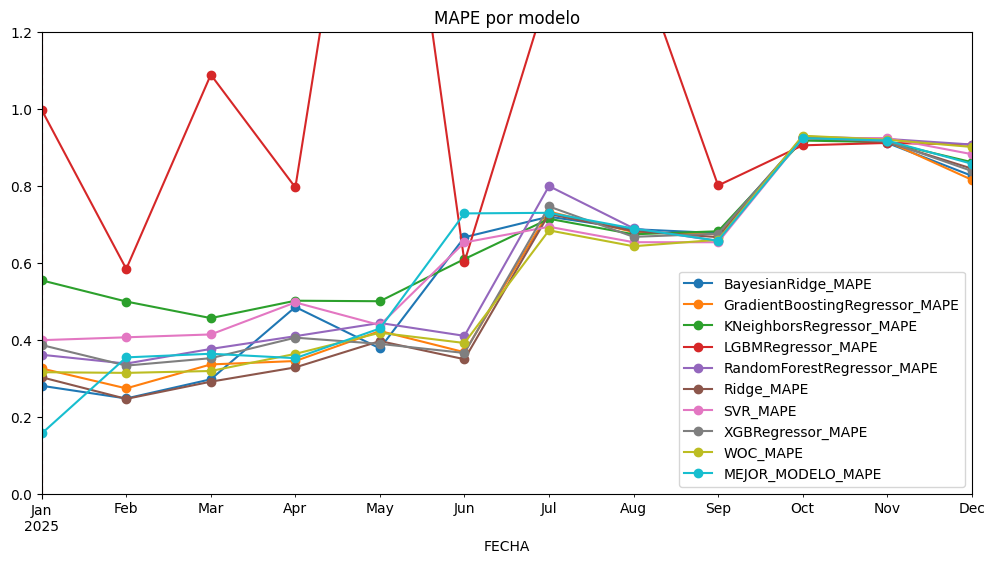

In [29]:
import matplotlib.pyplot as plt
MAPE_COLS = out.loc[:, out.columns.str.contains("_MAPE") & ~out.columns.str.contains("AVG_MAPE|Min_")].columns

ax = out.groupby("FECHA")[MAPE_COLS].mean().plot(figsize = (12,6), marker = 'o', title = "MAPE por modelo")

plt.axvline(x="2025-01-01", color='red', linestyle='--')

ax.set_ylim(0, 1.2)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2188664257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]
C:\Users\adojeda\AppData\Local\Temp\ipykernel_6732\2188664257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.FECHA = pd.to_datetime(df.FECHA)


calulamos mape ----------------------------------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


(0.2, 1.2)

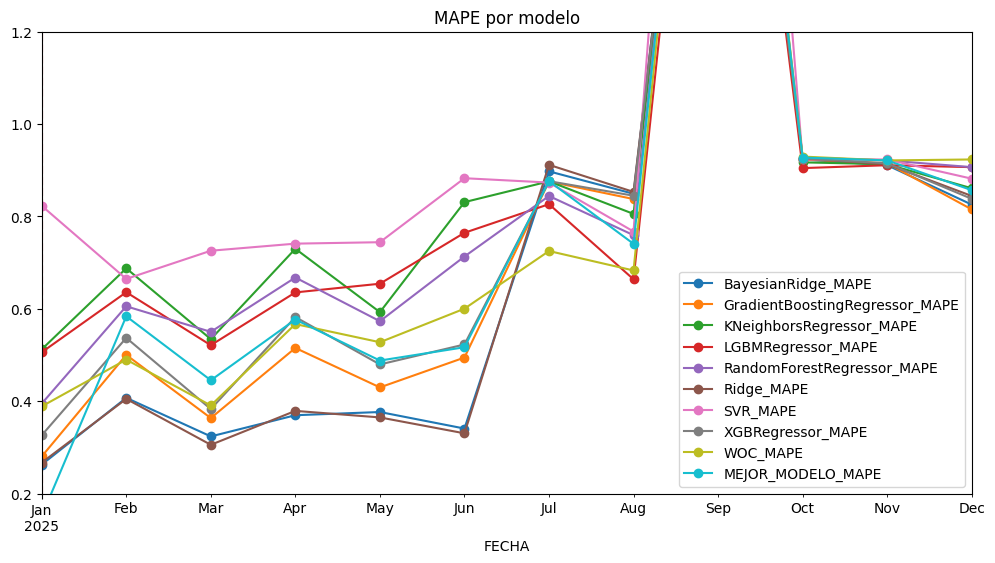

In [30]:
def process_pop(df):

    df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

    df.FECHA = pd.to_datetime(df.FECHA)

    #FILTRO LIMITE INFERIOR
    df = df [df.FECHA >= "2024-01-01"]

    #FILTRO LIMITE SUPERIOR?

    #df = df [df.FECHA <= date_forecas]

    df['Segmento'] = np.where ((df.FECHA >= "2024-01-01") & (df.FECHA <= "2025-01-01"), "Validacion", "Pronostico")

    # Agregando modelo WOC
    df['WOC'] = df.mean(numeric_only = True, axis = 1)

    cols2mape = ["BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor" , "WOC"]

    # FUNCION MAPE DEACERO
    def asignar_valor(df, col1, col2):
        try: 
            if df[col1] < 1 and df[col2] < 1:
                return 0
            elif df[col1] >= 1 and df[col2] < 1:      
                return 1
            elif df[col1] < 1 and df[col2] >= 1:
                return 1
            else:
                return abs(df[col1] - df[col2]) / df[col1]
        except:
            return None

    # FUNCION promedio mape
    def kashyyyk(x):
        return x.mean()

    # calculamos mape
    print("calulamos mape ----------------------------------------------")
    for col in cols2mape:
        print(col)
        df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

    # agrupamos para calculo de avg mape
    tattoine = df.groupby(['SUBG3', 'Segmento'])

    print("calulamos avg_mape a grupo -----------------------")
    # iteramos sobre calculo avg mape
    for col in cols2mape:
        print(col)

        df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
        
        # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
        #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

        # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
        df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')

    avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

    # Seleccionando menor MAPE
    df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

    kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

    df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

    # eliminamos palabra AVG_MAPE_
    df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

    anakin = df.melt('MAX_Modelo', ignore_index = False)

    df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

    def desviacion(df, col1, col2):
        try: 
            if df[col1] <= 0.1 and df[col2] <= 0.1:
                return 0
            elif df[col1] <= 0.1 and df[col2] > 0.1:
                return 1
            elif df[col1] > 0.1 and df[col2] <= 0.1:
                return 1
            else:
                return df[col1]/df[col2]
        except: 
            return None

    df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)

    # CALCULAMOS ESTATUS DE STD 
    def estatus(df, col):
        if df[col] > 0.5:
            val = 'Desviacion alta'
        else:
            val = 'Desviacion baja'
        return val

    df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

    df["MEJOR_MODELO_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = "MAX_Valores", axis = 1)

    df.head()
    
    return df


out = process_pop(base_t[base_t.MAX_MODEL == True])

MAPE_COLS = out.loc[:, out.columns.str.contains("_MAPE") & ~out.columns.str.contains("AVG_MAPE|Min_")].columns

ax = out.groupby("FECHA")[MAPE_COLS].mean().plot(figsize = (12,6), marker = 'o', title = "MAPE por modelo")

plt.axvline(x="2025-01-01", color='red', linestyle='--')


ax.set_ylim(0.2, 1.2)


(140000.0, 200000.0)

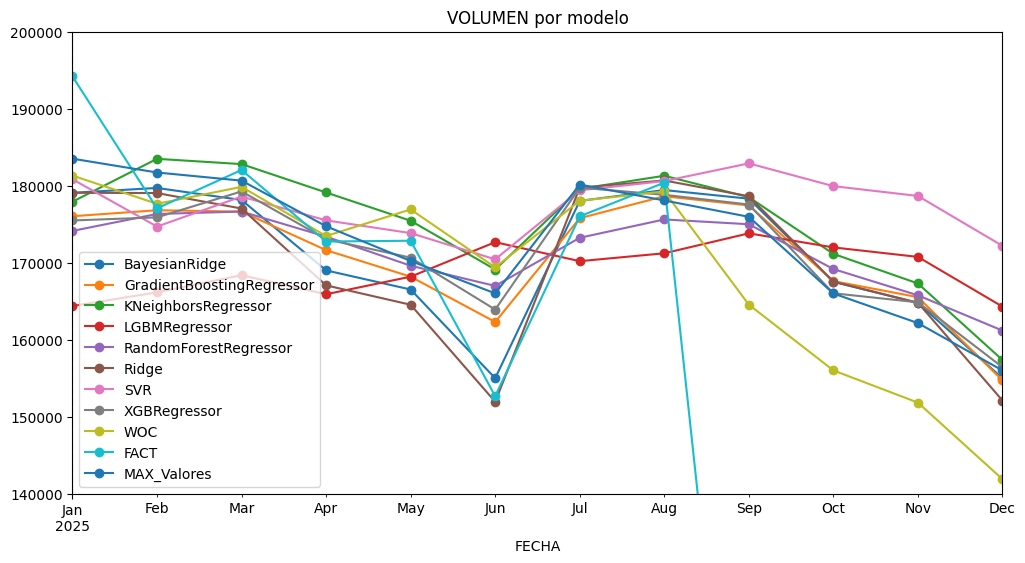

In [31]:
cols2mape = [ "BayesianRidge", "GradientBoostingRegressor", "KNeighborsRegressor", "LGBMRegressor", "RandomForestRegressor", "Ridge", "SVR", "XGBRegressor" , "WOC", "FACT", "MAX_Valores"]

ax = out.groupby("FECHA")[cols2mape].sum().plot(figsize = (12,6), marker = 'o', title = "VOLUMEN por modelo")

plt.axvline(x="2025-01-01", color='red', linestyle='--')

ax.set_ylim(140000, 200000)

(160000.0, 200000.0)

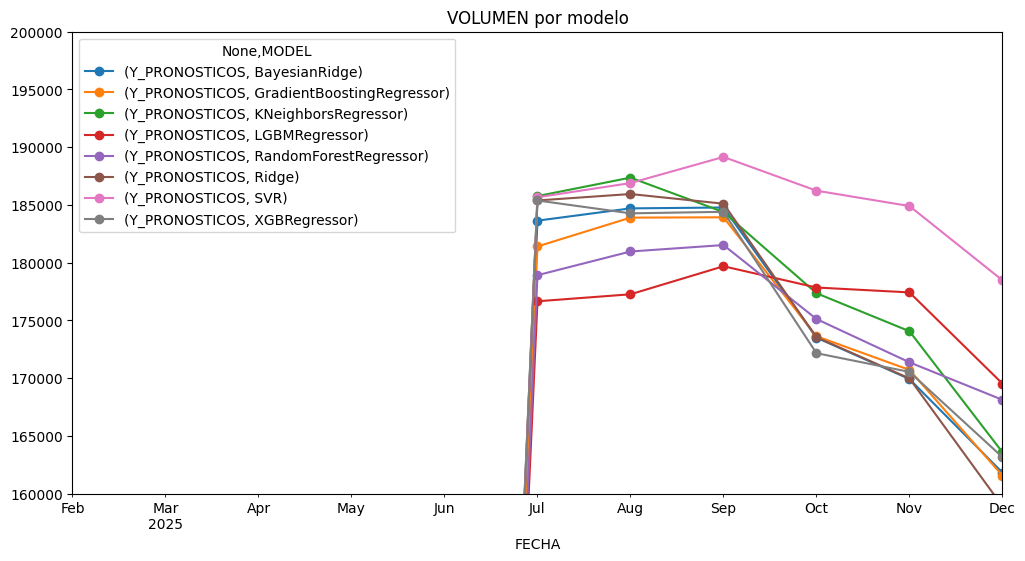

In [32]:
base["VALID"] = np.where((base.FECHA >= "2024-01-01") & (base.FECHA <= "2025-01-01"), "01-Validacion", "02-Pronostico")
ax = base[base.VALID=="02-Pronostico"].groupby(["FECHA", "MODEL"])[["Y_PRONOSTICOS"]].sum().round(0).unstack(-1).plot(figsize = (12,6), marker = 'o', title = "VOLUMEN por modelo")
ax.set_ylim(160000, 200000)

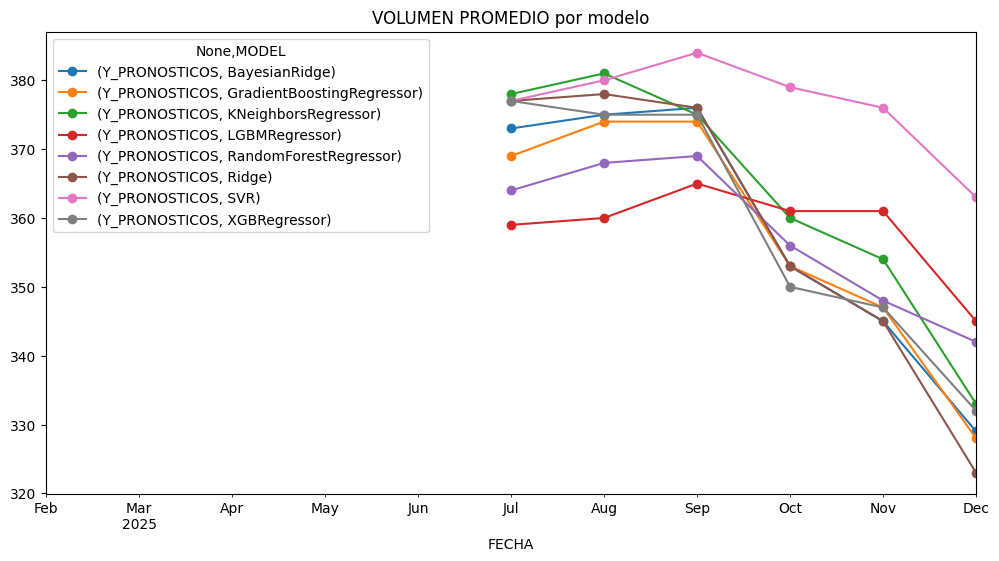

In [33]:
base["VALID"] = np.where((base.FECHA >= "2024-01-01") & (base.FECHA <= "2025-01-01"), "01-Validacion", "02-Pronostico")
ax = base[base.VALID=="02-Pronostico"].groupby(["FECHA", "MODEL"])[["Y_PRONOSTICOS"]].mean().round(0).unstack(-1).plot(figsize = (12,6), marker = 'o', title = "VOLUMEN PROMEDIO por modelo")
#ax.set_ylim(160000, 200000)

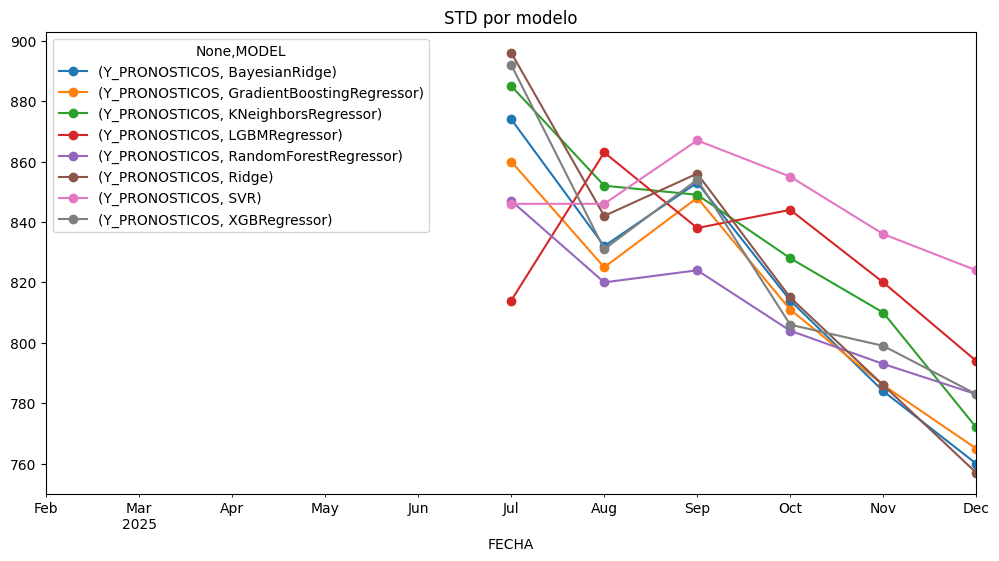

In [34]:
base["VALID"] = np.where((base.FECHA >= "2024-01-01") & (base.FECHA <= "2025-01-01"), "01-Validacion", "02-Pronostico")
ax = base[base.VALID=="02-Pronostico"].groupby(["FECHA", "MODEL"])[["Y_PRONOSTICOS"]].std().round(0).unstack(-1).plot(figsize = (12,6), marker = 'o', title = "STD por modelo")
#ax.set_ylim(160000, 200000)